# Check cutflow for nanoaod samples

In [9]:
import os, subprocess
import json
import uproot
import awkward as ak
import numpy as np
from coffea import processor, util, hist
import pandas as pd
import pickle

#Plot settings
%matplotlib inline
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
#mpl.rcParams['lines.linewidth'] = 5

#Dataset parameters
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.9

with open('../xsec.json') as f:
    xs = json.load(f)

with open('../pmap.json') as f:
    pmap = json.load(f)

systematics = ['nominal',
               'jet_triggerUp','jet_triggerDown',
               'btagWeightUp','btagWeightDown','btagEffStatUp','btagEffStatDown',
               'UESUp','UESDown','JESUp','JESDown','JERUp','JERDown',
              ]

mc = ['QCD', 'ttbar', 'singlet', 'Wjets','Zjets','VV','EWKZ','EWKW','ggF','VBF','WH','ZH']


#To calculate significance
def significance(s,b):
    if b==0:
        return 0
    z_squared = 2.0*(s+b)*np.log(1.0+1.0*s/b) - 2.0*s
    return np.sqrt(z_squared)

To start the analysis you might want to run `make_pkl.py` first!

In [2]:
picklename = "2017_pt/templates.pkl"

In [3]:
# Read the histogram from the pickle file
cutflow_0 = pickle.load(open(picklename,'rb')).integrate('region',['signal'])

In [4]:
cutflow_axes = ['msd1', 'msd2', 'ddb1', 'ddc2','j1pt','j2pt']

In [5]:
cutflow_0

<Hist (process,msd1,msd2,ddb1,ddc2,j1pt,j2pt) instance at 0x7fa041fa22b0>

In [31]:
cutflow_0.axis('process').identifiers()

[<StringBin (EWKW) instance at 0x7fa0427f8e20>,
 <StringBin (EWKZ) instance at 0x7fa0427f8df0>,
 <StringBin (QCD) instance at 0x7fa0427f2220>,
 <StringBin (QCDHT) instance at 0x7fa0427e89a0>,
 <StringBin (VBF) instance at 0x7fa041fa20d0>,
 <StringBin (VBFDipoleRecoilOff) instance at 0x7fa041fa2130>,
 <StringBin (VV) instance at 0x7fa0427f8c10>,
 <StringBin (WH) instance at 0x7fa041fa2220>,
 <StringBin (Wjets) instance at 0x7fa0427f8d00>,
 <StringBin (ZH) instance at 0x7fa041fa2280>,
 <StringBin (Zjets) instance at 0x7fa0427f8f70>,
 <StringBin (ZjetsHT) instance at 0x7fa0427f8f40>,
 <StringBin (data) instance at 0x7fa041fa23a0>,
 <StringBin (ggF) instance at 0x7fa0427f85e0>,
 <StringBin (muondata) instance at 0x7fa041fa2430>,
 <StringBin (singlet) instance at 0x7fa0427f8940>,
 <StringBin (ttH) instance at 0x7fa041fa2340>,
 <StringBin (ttbar) instance at 0x7f9fd28243d0>]

## Create cutflow tables

In [39]:
def create_cutflow_tab_j2pt(cutflow):
    
    ddb_thres = 0.87
    ddc_thres = 0.02
    j1pt_cut = 400

    cutflow = cutflow.sum(*['msd1', 'msd2'], overflow='all')
    
    #New label for columns
    cols = [">={}".format(x) for x in cutflow.axis('j2pt').edges()]
    edge_vals = cutflow.axis('j2pt').edges() #Coresponding edge value to use later

    df = pd.DataFrame(index = mc, columns = cols)
    
    #loop over the processes and ddc2 scores and calcualte the events
    for process in mc:
        for thres in edge_vals:
            try:
                df.loc[process, ">={}".format(thres)] = cutflow.integrate('process', process)\
                                                               .integrate('ddb1', slice(ddb_thres,1.))\
                                                               .integrate('ddc2', slice(ddc_thres,1.))\
                                                               .integrate('j1pt', slice(j1pt_cut,1200))\
                                                               .integrate('j2pt', slice(thres,1200)).values()[()]
            except:
                continue

    return df

In [40]:
create_cutflow_tab_j2pt(cutflow_0)

,>=0.0,>=200.0,>=300.0,>=400.0,>=450.0,>=1200.0
QCD,11.472096,11.472096,11.472096,10.491186,7.149439,0.0
ttbar,5.117432,5.117432,4.507677,3.291214,3.044957,0.0
singlet,0.677223,0.677223,0.677223,0.614292,0.614292,0.0
Wjets,1.479093,1.479093,1.479093,1.324443,1.296434,0.0
Zjets,11.515885,11.515885,11.200949,9.551297,8.129888,0.0
VV,2.266244,2.266244,2.266244,1.804592,1.610431,0.0
EWKZ,0.0,0.0,0.0,0.0,0.0,0.0
EWKW,0.083181,0.083181,0.083181,0.0,0.0,0.0
ggF,0.291981,0.291981,0.291981,0.245329,0.152813,0.0
VBF,0.07344,0.07344,0.070204,0.066995,0.066995,0.0


In [43]:
def create_cutflow_tab_j1pt(cutflow):
    
    ddb_thres = 0.87
    ddc_thres = 0.02
    j2pt_cut = 400

    cutflow = cutflow.sum(*['msd1', 'msd2'], overflow='all')
    
    #New label for columns
    cols = [">={}".format(x) for x in cutflow.axis('j1pt').edges()]
    edge_vals = cutflow.axis('j1pt').edges() #Coresponding edge value to use later

    df = pd.DataFrame(index = mc, columns = cols)
    
    #loop over the processes and ddc2 scores and calcualte the events
    for process in mc:
        for thres in edge_vals:
            try:
                df.loc[process, ">={}".format(thres)] = cutflow.integrate('process', process)\
                                                               .integrate('ddb1', slice(ddb_thres,1.))\
                                                               .integrate('ddc2', slice(ddc_thres,1.))\
                                                               .integrate('j2pt', slice(j2pt_cut,1200))\
                                                               .integrate('j1pt', slice(thres,1200)).values()[()]
            except:
                continue

    return df

In [44]:
create_cutflow_tab_j1pt(cutflow_0)

,>=0.0,>=200.0,>=300.0,>=400.0,>=450.0,>=1200.0
QCD,19.752471,19.752471,19.752471,10.491186,9.642304,0.0
ttbar,3.877703,3.877703,3.578795,3.291214,2.673843,0.0
singlet,0.614292,0.614292,0.614292,0.614292,0.614292,0.0
Wjets,1.408713,1.408713,1.408713,1.324443,1.296434,0.0
Zjets,11.554295,11.554295,11.278822,9.551297,8.300375,0.0
VV,1.847846,1.847846,1.847846,1.804592,1.396168,0.0
EWKZ,0.0,0.0,0.0,0.0,0.0,0.0
EWKW,0.0,0.0,0.0,0.0,0.0,0.0
ggF,0.245329,0.245329,0.245329,0.245329,0.245329,0.0
VBF,0.066995,0.066995,0.066995,0.066995,0.066995,0.0


## Plot the samples

In [56]:
def plot_signal(cutflow, j1pt_cut = 300, j2pt_cut = 300):
    
    ddb_thres = 0.87
    ddc_thres = 0.02
    
    cutflow_sum = cutflow.sum(*['msd2'], overflow='all')
    
    proc_list =  ['ZH']
    
    for proc in proc_list:   
        cutflow_integrate = cutflow_sum.integrate('process', proc)\
                                        .integrate('ddb1', slice(ddb_thres,1.))\
                                        .integrate('ddc2', slice(ddc_thres,1.))\
                                        .integrate('j1pt', slice(j1pt_cut,1200))\
                                        .integrate('j2pt', slice(j2pt_cut,1200))
    
        hist.plot1d(cutflow_integrate)
    
    plt.legend(proc_list)
    plt.show()

/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:43: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(


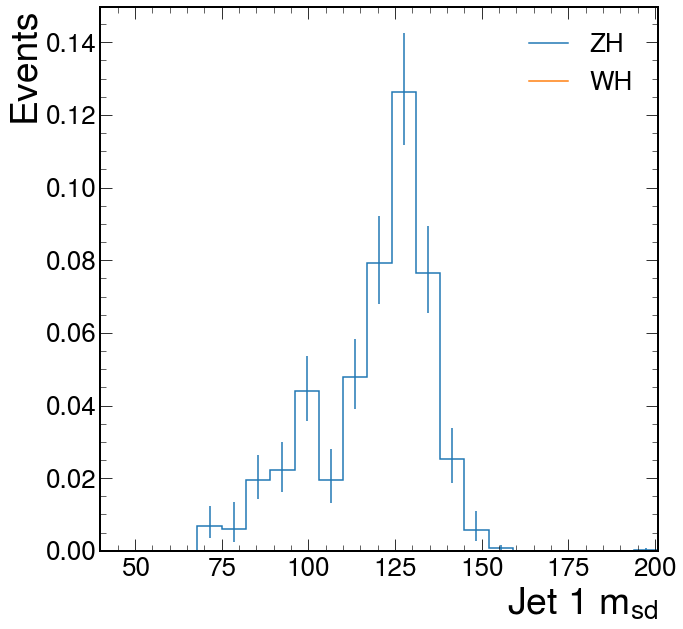

In [59]:
plot_signal(cutflow_0, j1pt_cut = 450, j2pt_cut = 400)

In [70]:
def plot_signal_j2pt(cutflow, j1pt_cut = 400, j2pt_cuts = [300,400,450]):
    
    ddb_thres = 0.87
    ddc_thres = 0.02
    
    cutflow_sum = cutflow.sum(*['msd2'], overflow='all')
    
    proc_list =  ['ZH']
    
    for proc in proc_list:
        for j2pt_cut in j2pt_cuts:
            cutflow_integrate = cutflow_sum.integrate('process', proc)\
                                            .integrate('ddb1', slice(ddb_thres,1.))\
                                            .integrate('ddc2', slice(ddc_thres,1.))\
                                            .integrate('j1pt', slice(j1pt_cut,1200))\
                                            .integrate('j2pt', slice(j2pt_cut,1200))

            hist.plot1d(cutflow_integrate)
            
    plt.ylim([0,0.18])
    plt.legend(['ZH_j2pt_'+str(x) for x in j2pt_cuts])
    plt.show()

/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWa

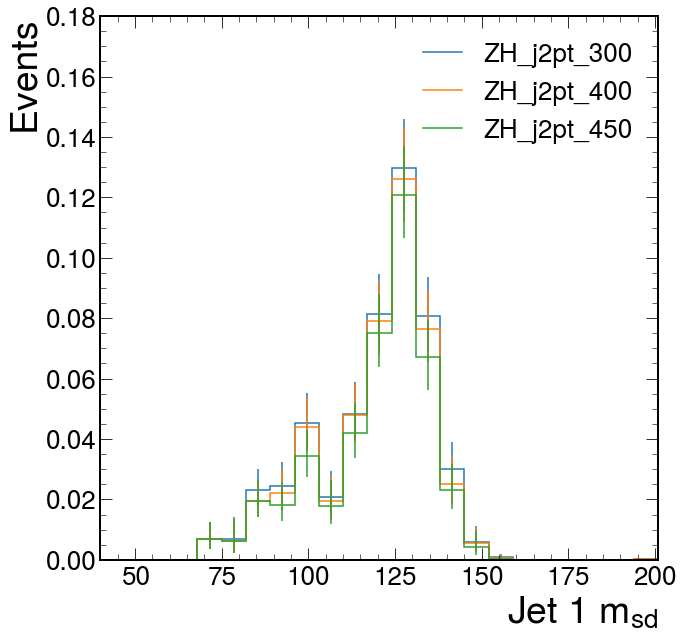

In [73]:
plot_signal_j2pt(cutflow_0, j1pt_cut = 450)

In [45]:
cutflow_sum = cutflow_0.sum(*['msd1', 'msd2'], overflow='all')

In [ ]:
hist.plot1d(cutflow_sum

/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWa

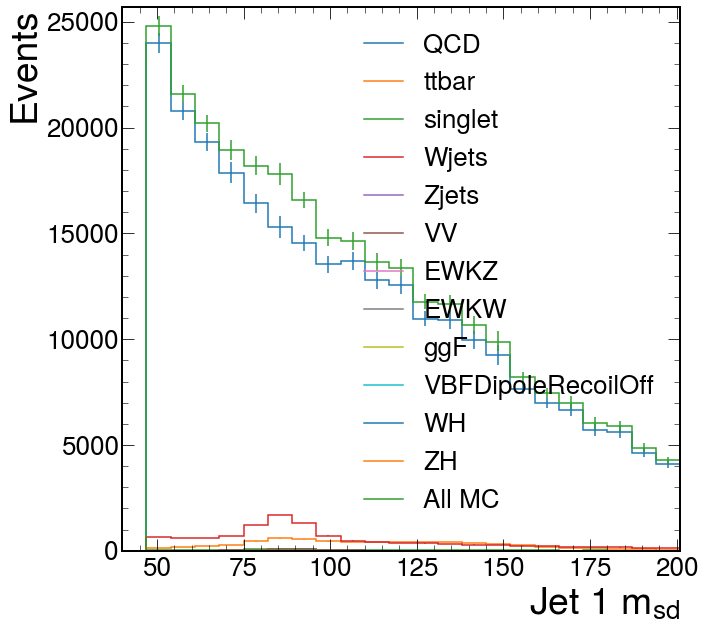

In [132]:
for proc in mc: 
    hist.plot1d(cutflow_sum.integrate('process', proc))

hist.plot1d(cutflow_sum.integrate('process', mc, overflow='all'))
plt.legend(mc+['All MC'])

In [141]:
def plot_sample_ddb_ddc_pass(cutflow):
    
    cutflow_sum = cutflow.sum(*['genflavor1', 'genflavor2', 'msd2','j2pt'], overflow='all').integrate('ddb1', slice(0.87,1)).integrate('ddc2',slice(0.02,1))
    
    proc_list =  ['ZH','WH', 'QCD', 'ttbar']
    for proc in proc_list: 
        hist.plot1d(cutflow_sum.integrate('process', proc))
    
    #hist.plot1d(cutflow_sum.integrate('process', mc, overflow='all'))
    #plt.legend(mc+['All MC'])
    
    plt.legend(proc_list)
    plt.show()

/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWa

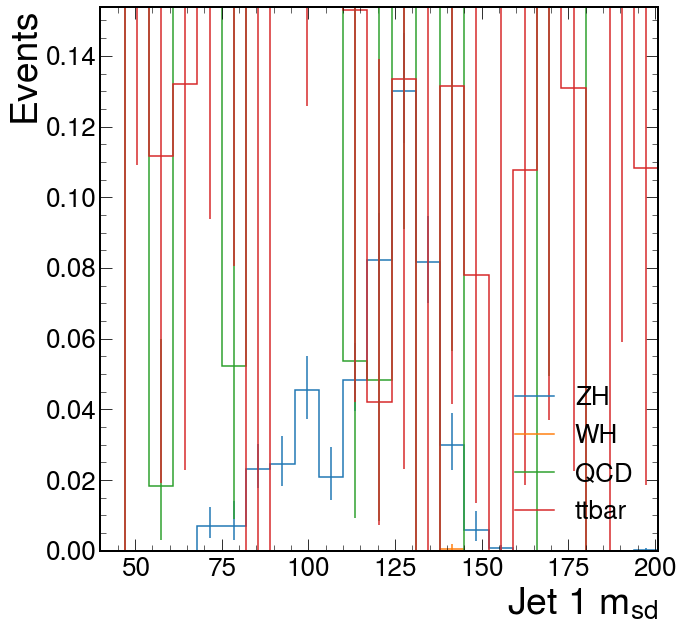

In [142]:
plot_sample_ddb_ddc_pass(cutflow_0)

## Jet 1 and Jet 2 pT

In [2]:
picklename = "2017_pt/templates.pkl"

In [3]:
# Read the histogram from the pickle file
cutflow_pt = pickle.load(open(picklename,'rb')).integrate('region',['signal'])

In [6]:
cutflow_axes = ['msd1', 'msd2', 'ddb1', 'ddc2','j1pt','j2pt']
templates_pt = cutflow_pt.sum(*['msd1', 'msd2', 'ddb1', 'ddc2'], overflow='all')

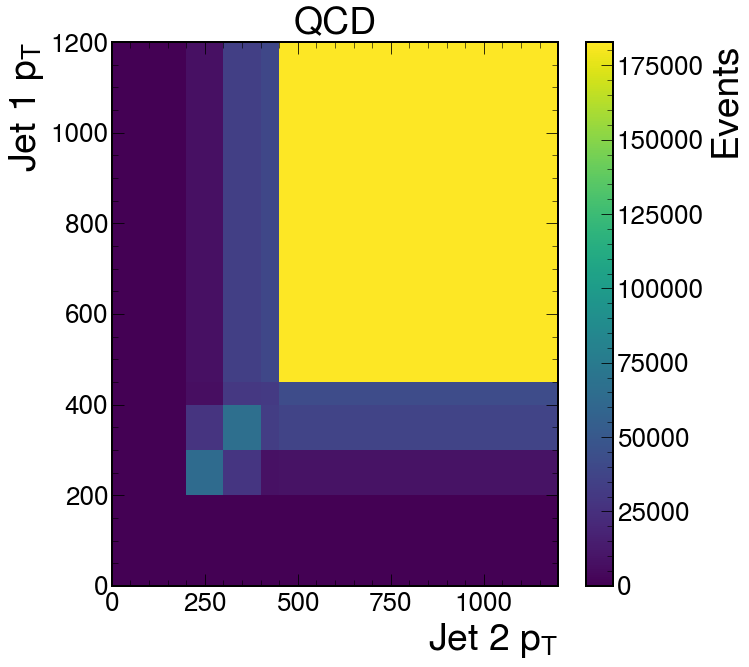

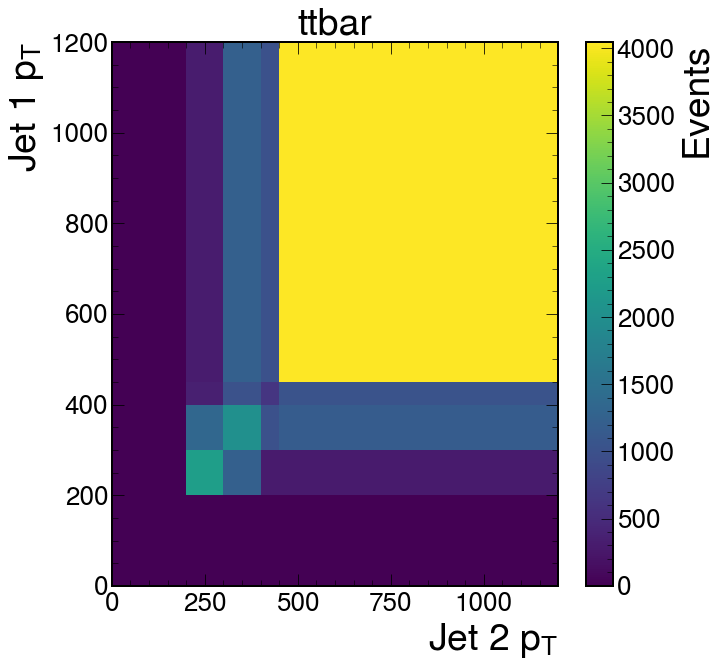

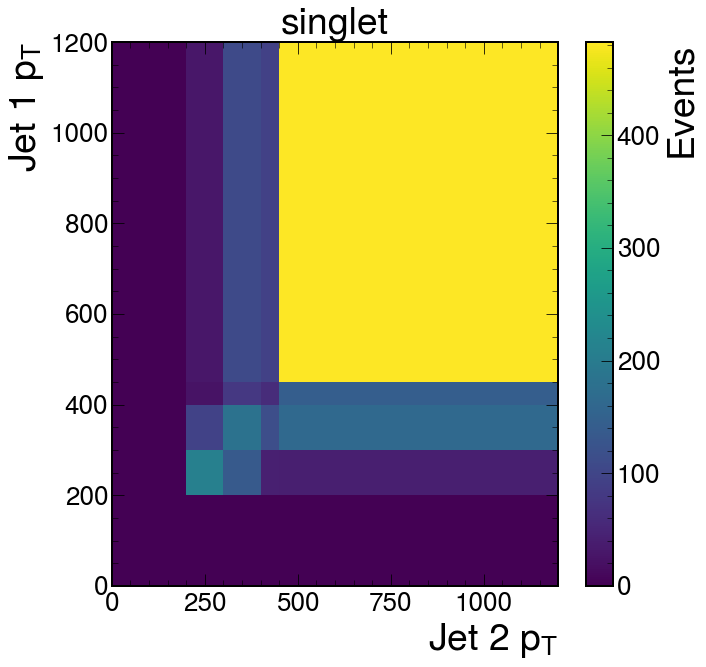

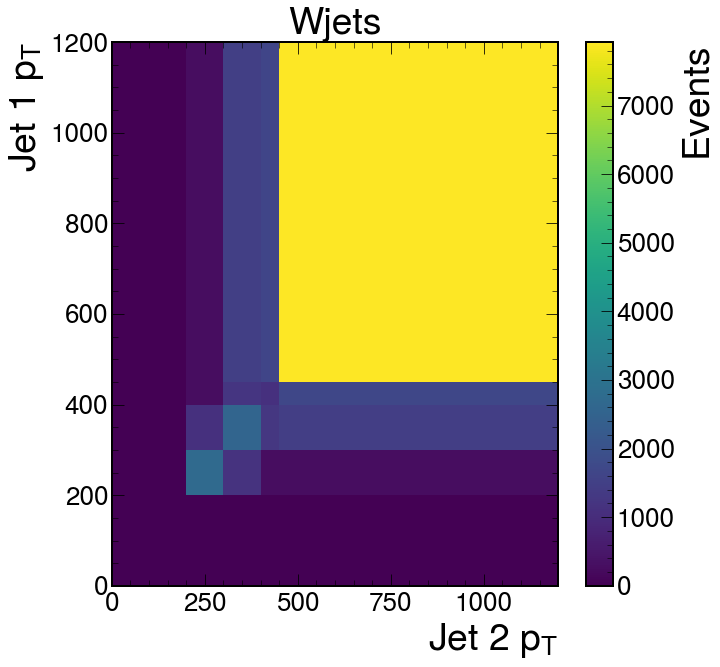

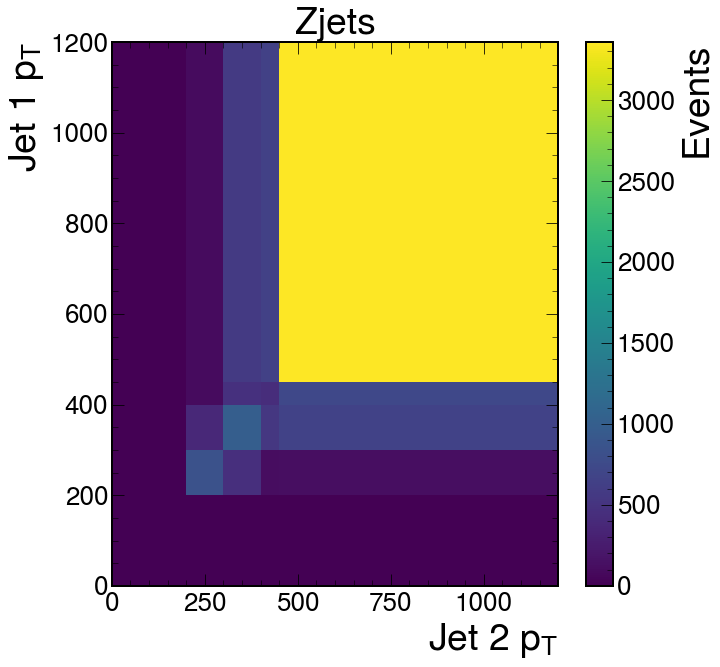

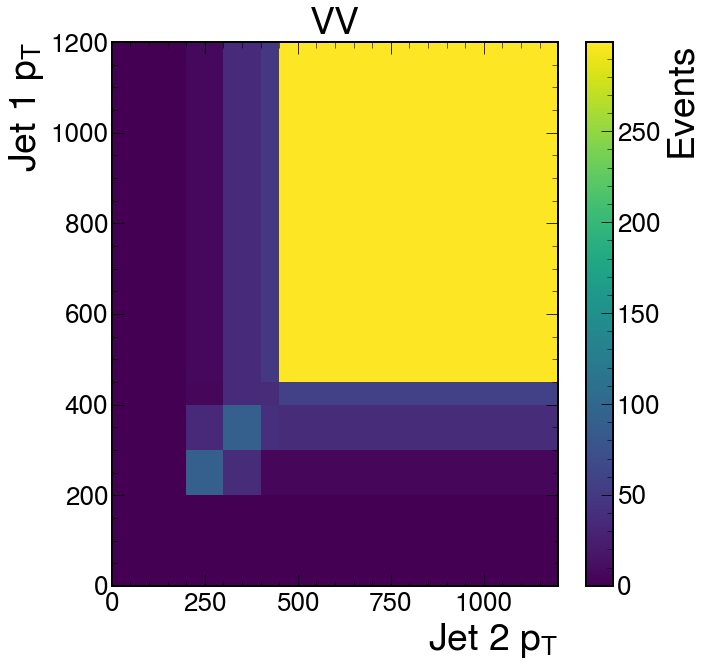

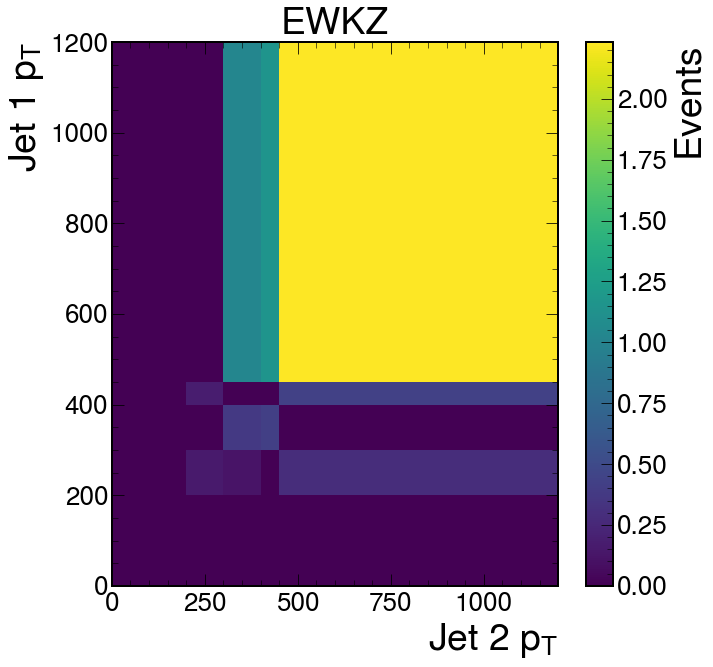

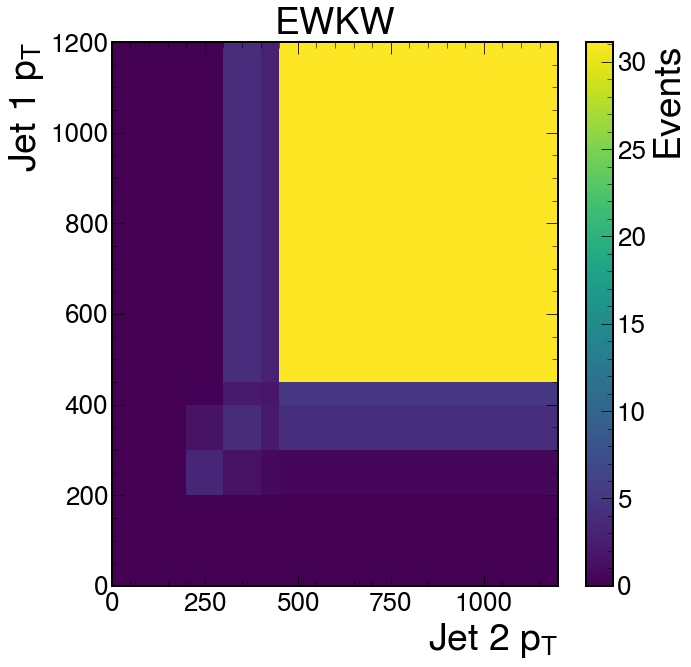

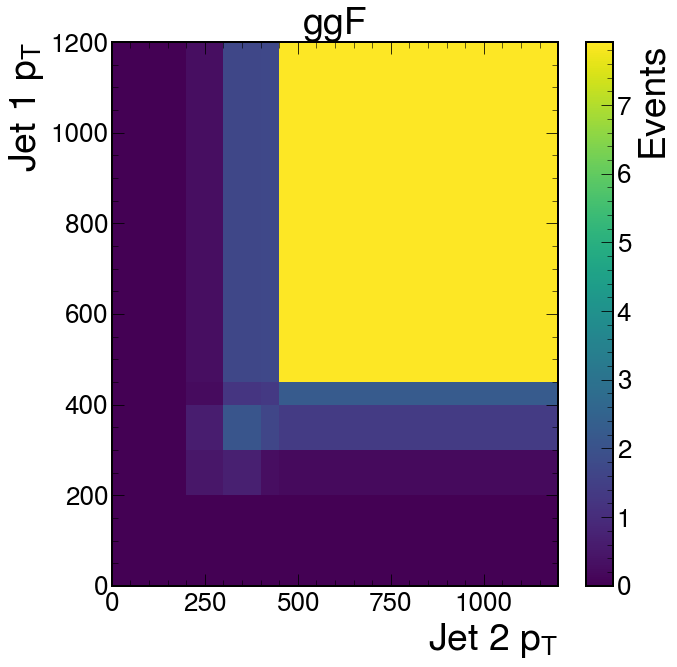

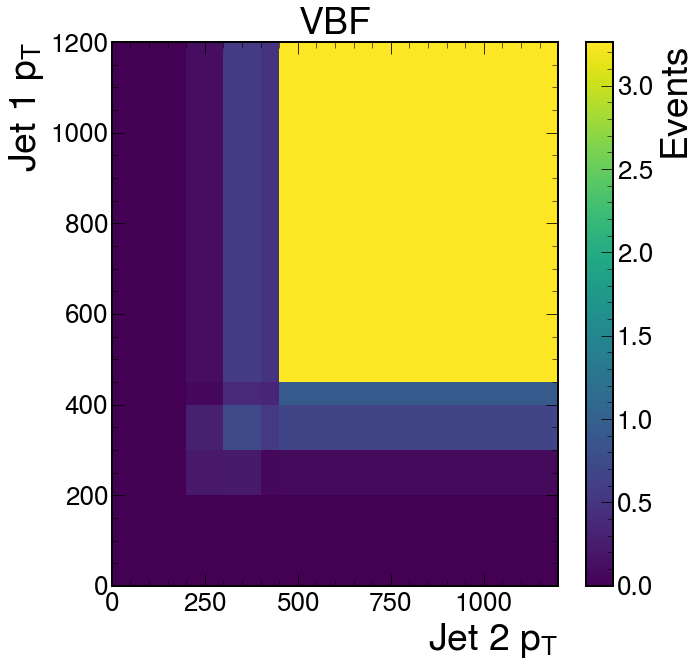

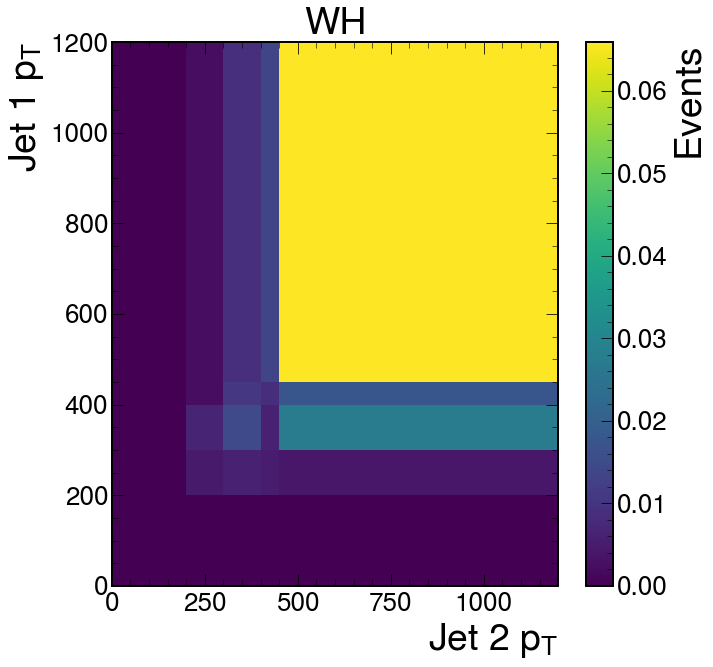

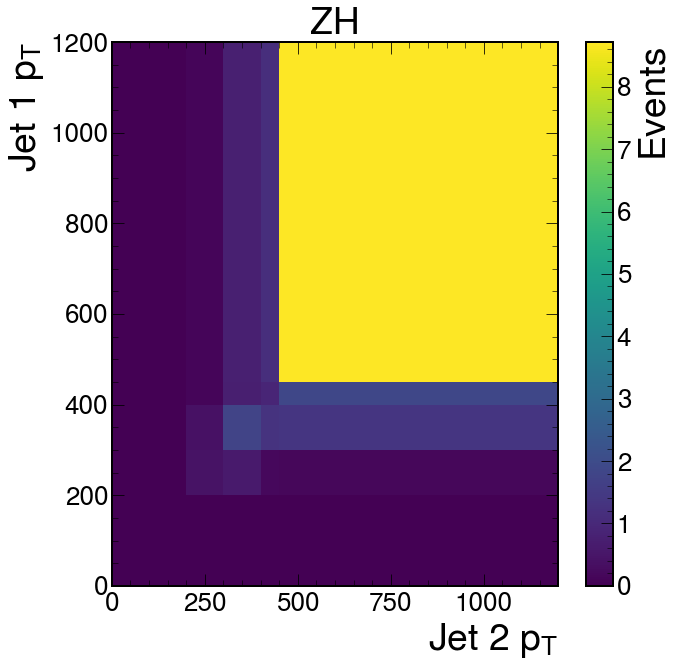

In [8]:
for proc in mc:
    hist.plot2d(templates_pt.integrate('process', proc), xaxis = 'j2pt')
    plt.title(proc)
    plt.show()

ValueError: plot2d() can only support exactly two dimensions

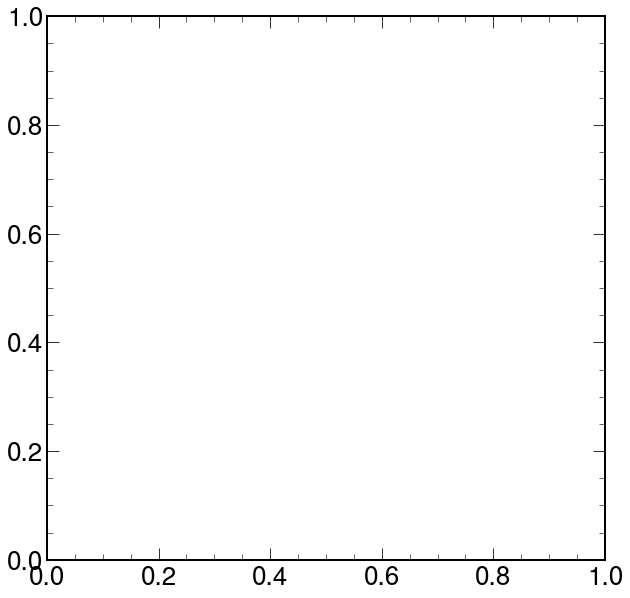

In [7]:
hist.plot2d(templates_pt, xaxis = 'j2pt')